In [1]:
from pyhail import hdr, hsda, common, hacc, mesh_ppi

import find_column_maximum

import pyodim
import pyart

import matplotlib.pyplot as pl
import matplotlib.colors as colors
import numpy as np

from time import time
import os
from urllib import request


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#download example radar data

# filename = '/g/data/kl02/jss548/aura/testing_files/hailcore/97_20241121_023000.pvol.hailcore.h5'

radar_url = 'https://pyhail-public.s3.ap-southeast-2.amazonaws.com/66_20231110_063000.pvol.h5'
tmp_path = '/tmp/pyhail_example_data'
os.makedirs(tmp_path, exist_ok=True)
filename = f'{tmp_path}/66_20231110_063000.pvol.h5' #This example is from Brisbane radar on the 10-11-2023 at 06:30 UTC+0
if not os.path.exists(filename):
    request.urlretrieve(radar_url, filename)

#load radar data
radar_datasets = pyodim.read_odim(filename, lazy_load=False)

In [3]:
#add HCA
for sweep in range(len(radar_datasets)):
    #xtract HCA
    hca_meta = common.get_odim_ncar_hca(radar_datasets[sweep]['elevation'].data[0], filename,
                                        radar_datasets[sweep]['DBZH'].shape, 
                                        skip_birdbath=True)
    #insert in dataset dict
    radar_datasets[sweep] = radar_datasets[sweep].merge(
        {'HCA': (("azimuth", "range"), hca_meta['data']) })
    # HCA metadata has not been added for pyodim

#get list of elevations, and lowest sweep index
n_ppi = len(radar_datasets)
elevation_dataset = []
for sweep_idx in range(n_ppi):
    elevation_dataset.append(radar_datasets[sweep_idx]['elevation'].data[0])
sweep0_idx = np.argmin(elevation_dataset)

#run retrievals
timer = time()
radar_datasets = hdr.pyodim(radar_datasets,
                            'DBZH',
                            'ZDR')
print('HDR:', time()-timer,  's')
timer = time()

radar_datasets = hsda.pyodim(radar_datasets, 
                                'DBZH', 
                                'ZDR', 
                                'RHOHV', 
                                'HCA',
                                [4000, 5500], 
                                [6, 7, 8])
print('HSDA:', time()-timer, 's')
timer = time()

radar_datasets = mesh_ppi.pyodim(radar_datasets,
                                    'DBZH',
                                    [4000, 5500])
print('MESH PPI:', time()-timer, 's')
timer = time()

radar_datasets = hacc.pyodim(radar_datasets, 
                                'DBZH',
                                sweep0_idx, 
                                sweep0_idx,
                                4000, 
                                700)
print('HACC:', time()-timer, 's')
timer = time()



HDR: 0.03548550605773926 s
HSDA: 1.451188087463379 s
MESH PPI: 1.6919395923614502 s
HACC: 0.019471406936645508 s


In [4]:
output = find_column_maximum.pyodim(radar_datasets, 'hsda', column_altitude_maximum=10000)
print(np.nanmax(output))

3.0


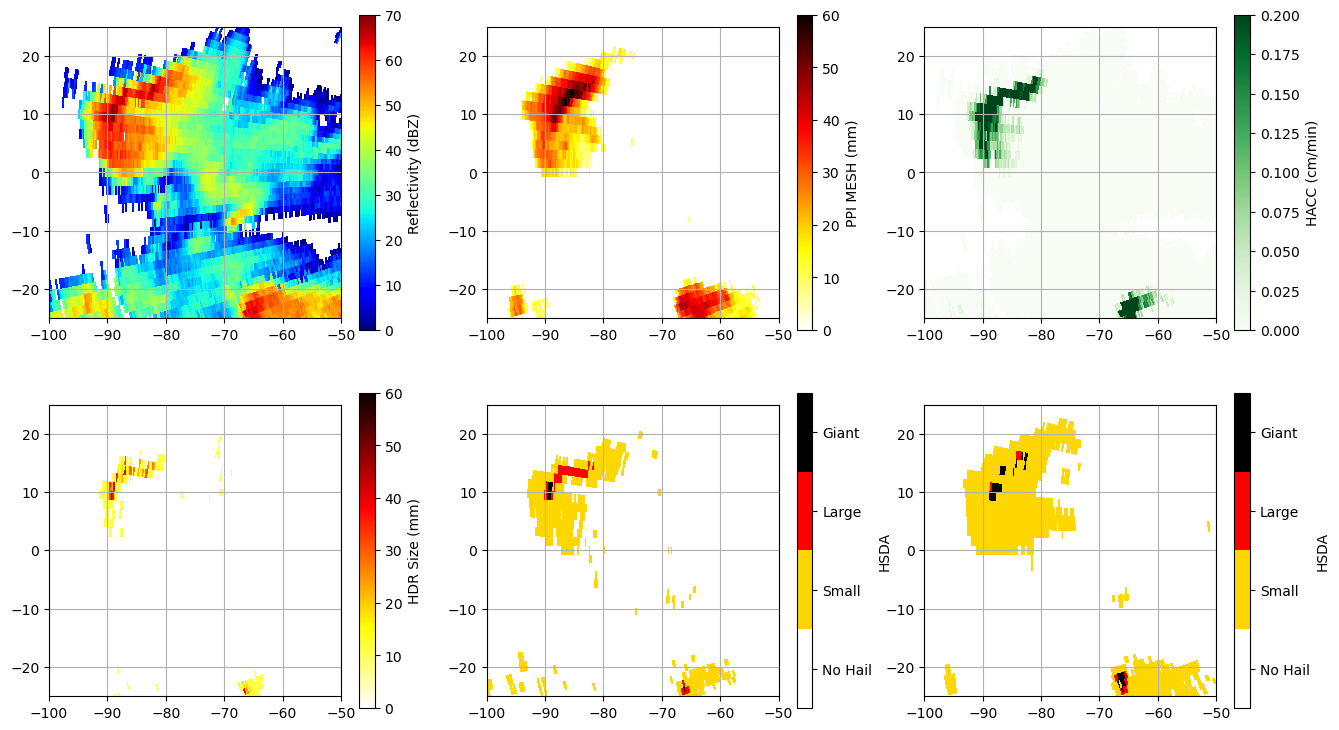

In [5]:
#plotting
#get edge coords for plotting
x_coords, y_coords, _ = pyart.core.antenna_vectors_to_cartesian(radar_datasets[sweep0_idx]['range'].data, 
                                        radar_datasets[sweep0_idx]['azimuth'].data, 
                                        radar_datasets[sweep0_idx]['elevation'].data, 
                                        edges=True)
x_coords = x_coords/1000
y_coords = y_coords/1000

x_lim = [-100,-50]
y_lim = [-25, 25]
hsda_colors = [
    "White",
    "Gold",
    "Red",
    "Black",
    ]
hsda_cmap = colors.ListedColormap(hsda_colors) 

fig, axs = pl.subplots(nrows=2, ncols=3, figsize=(16, 9))
axs = axs.flatten()

im = axs[0].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['DBZH'].values, cmap='jet', vmin=0, vmax=70)
cbar = fig.colorbar(im, ax=axs[0], label='Reflectivity (dBZ)')

im = axs[1].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['mesh'].values, cmap='hot_r', vmin=0, vmax=60)
cbar = fig.colorbar(im, ax=axs[1], label='PPI MESH (mm)')

im = axs[2].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['hacc'].values, cmap='Greens', vmin=0, vmax=0.2)
cbar = fig.colorbar(im, ax=axs[2], label='HACC (cm/min)')

im = axs[3].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['hdr_size'].values, cmap='hot_r', vmin=0, vmax=60)
cbar = fig.colorbar(im, ax=axs[3], label='HDR Size (mm)')

im = axs[4].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['hsda'].values, cmap=hsda_cmap, vmin=-0.5, vmax=3.5)
cbar = fig.colorbar(im, ax=axs[4], label='HSDA')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(["No Hail", "Small", "Large", "Giant"])

im = axs[5].pcolormesh(x_coords, y_coords, output, cmap=hsda_cmap, vmin=-0.5, vmax=3.5)
cbar = fig.colorbar(im, ax=axs[5], label='HSDA')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(["No Hail", "Small", "Large", "Giant"])


for ax in axs:
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.grid()
    ax.set_aspect('equal', 'box')
